In [1]:
from backtester.datahandler import HistoricalOptionsData, TiingoData
from backtester.strategy import Strategy, StrategyLeg 
from backtester import Type, Direction, Stock
from backtester import Backtest
from backtester.strategy import Strangle
from backtester.statistics import monthly_returns_heatmap, returns_histogram, returns_chart

In [2]:
data = HistoricalOptionsData("allspx/SPX_2017.csv")
schema = data.schema

In [3]:
stock_data = TiingoData('./data/portfolio_data_2017.csv')

In [4]:
short_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 2)

short_straddle.add_legs([leg1, leg2]);

In [5]:
VOO = Stock('VOO', 0.1)
TUR = Stock('TUR', 0.05)
RSX = Stock('RSX', 0.05)
EWY = Stock('EWY', 0.05)
EWS = Stock('EWS', 0.05)
VTIP = Stock('VTIP', 0.10)
TLT = Stock('TLT', 0.20)
BWX = Stock('BWX', 0.10)
PDBC = Stock('PDBC', 0.05)
IAU = Stock('IAU', 0.15)
VNQI = Stock('VNQI', 0.10)

In [6]:
0.1 + 0.05 + 0.05 + 0.05 + 0.05 + 0.10 + 0.20 + 0.10 + 0.05 + 0.15 + 0.10

1.0000000000000002

In [7]:
stocks = [
    VOO,
    TUR,
    RSX,
    EWY,
    EWS,
    VTIP,
    TLT,
    BWX,
    PDBC,
    IAU,
    VNQI
]

In [8]:
data._data['quotedate'] = data._data['quotedate'].apply(lambda x: x.tz_localize('UTC'))

In [9]:
bt = Backtest({'stocks': 0.99, 'options': 0.01, 'cash': 0})
bt.stocks = stocks
bt._options_strategy = short_straddle
bt.options_data = data
bt.stock_data = stock_data

In [10]:
bt.run(rebalance_freq=1)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:38


leg_1                                                         \
              contract underlying expiration  type strike     cost      order   
0   SPX170217C02150000        SPX 2017-02-17  call   2150 -11480.0  Order.STO   
1   SPX170217C02150000        SPX 2017-02-17  call   2150  13130.0  Order.BTC   
2   SPX170317C02170000        SPX 2017-03-17  call   2170 -11350.0  Order.STO   
3   SPX170317C02170000        SPX 2017-03-17  call   2170  22640.0  Order.BTC   
4   SPX170421C02280000        SPX 2017-04-21  call   2280 -12370.0  Order.STO   
5   SPX170421C02280000        SPX 2017-04-21  call   2280   8490.0  Order.BTC   
6   SPX170519C02245000        SPX 2017-05-19  call   2245 -12060.0  Order.STO   
7   SPX170519C02245000        SPX 2017-05-19  call   2245  14560.0  Order.BTC   
8   SPX170616C02270000        SPX 2017-06-16  call   2270 -12120.0  Order.STO   
9   SPX170616C02270000        SPX 2017-06-16  call   2270  16290.0  Order.BTC   
10  SPX170721C02310000        SPX 2017-07-21  call   2310 -12510.0  Order.STO   
11  SPX170721C02310000        SPX 2017-07-21  call   2310  12170.0  Order.BTC   
12  SPX170818C02310000        SPX 2017-08-18  call   2310 -12370.0  Order.STO   
13  SPX170818C02310000        SPX 2017-08-18  call   2310  16720.0  Order.BTC   
14  SPX170915C02355000        SPX 2017-09-15  call   2355 -12270.0  Order.STO   
15  SPX170915C02355000        SPX 2017-09-15  call   2355  12350.0  Order.BTC   
16  SPX171020C02355000        SPX 2017-10-20  call   2355 -12840.0  Order.STO   
17  SPX171020C02355000        SPX 2017-10-20  call   2355  17790.0  Order.BTC   
18  SPX171117C02405000        SPX 2017-11-17  call   2405 -12740.0  Order.STO   
19  SPX171117C02405000        SPX 2017-11-17  call   2405  17510.0  Order.BTC   
20  SPX171215C02455000        SPX 2017-12-15  call   2455 -12650.0  Order.STO   
21  SPX171215C02455000        SPX 2017-12-15  call   2455  19250.0  Order.BTC   
22  SPX180119C02515000        SPX 2018-01-19  call   2515 -13990.0  Order.STO   

                 leg_2                                                       \
              contract underlying expiration type strike    cost      order   
0   SPX170217P02150000        SPX 2017-02-17  put   2150 -1120.0  Order.STO   
1   SPX170217P02150000        SPX 2017-02-17  put   2150   220.0  Order.BTC   
2   SPX170317P02170000        SPX 2017-03-17  put   2170  -930.0  Order.STO   
3   SPX170317P02170000        SPX 2017-03-17  put   2170   100.0  Order.BTC   
4   SPX170421P02280000        SPX 2017-04-21  put   2280 -1030.0  Order.STO   
5   SPX170421P02280000        SPX 2017-04-21  put   2280   360.0  Order.BTC   
6   SPX170519P02245000        SPX 2017-05-19  put   2245  -940.0  Order.STO   
7   SPX170519P02245000        SPX 2017-05-19  put   2245   150.0  Order.BTC   
8   SPX170616P02270000        SPX 2017-06-16  put   2270  -750.0  Order.STO   
9   SPX170616P02270000        SPX 2017-06-16  put   2270    90.0  Order.BTC   
10  SPX170721P02310000        SPX 2017-07-21  put   2310  -810.0  Order.STO   
11  SPX170721P02310000        SPX 2017-07-21  put   2310   265.0  Order.BTC   
12  SPX170818P02310000        SPX 2017-08-18  put   2310  -960.0  Order.STO   
13  SPX170818P02310000        SPX 2017-08-18  put   2310   145.0  Order.BTC   
14  SPX170915P02355000        SPX 2017-09-15  put   2355  -740.0  Order.STO   
15  SPX170915P02355000        SPX 2017-09-15  put   2355   125.0  Order.BTC   
16  SPX171020P02355000        SPX 2017-10-20  put   2355  -970.0  Order.STO   
17  SPX171020P02355000        SPX 2017-10-20  put   2355   115.0  Order.BTC   
18  SPX171117P02405000        SPX 2017-11-17  put   2405  -730.0  Order.STO   
19  SPX171117P02405000        SPX 2017-11-17  put   2405   125.0  Order.BTC   
20  SPX171215P02455000        SPX 2017-12-15  put   2455  -820.0  Order.STO   
21  SPX171215P02455000        SPX 2017-12-15  put   2455   145.0  Order.BTC   
22  SPX180119P02515000        SPX 2018-01-19  put   2515 -1000.0  Order.STO   

     totals    

In [11]:
bt.balance

,total capital,cash,calls capital,options capital,options qty,puts capital,stocks capital,stocks qty,% change,accumulated return
2017-01-02 00:00:00+00:00,1.000000e+06,1000000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 00:00:00+00:00,9.767215e+05,22858.490787,-11800.0,-13020.0,1.0,-1220.0,9.897415e+05,35248.0,-0.023278,0.976722
2017-01-04 00:00:00+00:00,9.814920e+05,22858.490787,-12640.0,-13530.0,1.0,-890.0,9.950220e+05,35248.0,0.004884,0.981492
2017-01-05 00:00:00+00:00,9.905463e+05,22858.490787,-12530.0,-13390.0,1.0,-860.0,1.003936e+06,35248.0,0.009225,0.990546
2017-01-06 00:00:00+00:00,9.847099e+05,22858.490787,-13350.0,-14040.0,1.0,-690.0,9.987499e+05,35248.0,-0.005892,0.984710
...,...,...,...,...,...,...,...,...,...,...
2017-12-22 00:00:00+00:00,1.079712e+06,26263.716990,-17740.0,-18050.0,1.0,-310.0,1.097762e+06,34825.0,0.003791,1.079712
2017-12-26 00:00:00+00:00,1.082893e+06,26263.716990,-17700.0,-17975.0,1.0,-275.0,1.100868e+06,34825.0,0.002947,1.082893
2017-12-27 00:00:00+00:00,1.088539e+06,26263.716990,-17700.0,-18010.0,1.0,-310.0,1.106549e+06,34825.0,0.005214,1.088539
2017-12-28 00:00:00+00:00,1.093571e+06,26263.716990,-17700.0,-17955.0,1.0,-255.0,1.111526e+06,34825.0,0.004623,1.093571


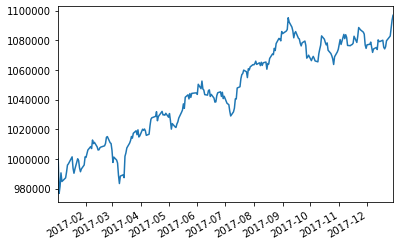

In [12]:
bt.balance['total capital'].plot();